In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-04-14 11:07:17.658875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744628837.928449      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744628838.004559      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=aac1e547aaa00b1e47b2682d068774b42aa8eddb4b2771b39ce1103203d403cf
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [3]:
data = pd.read_csv('/kaggle/input/eurusd60/EURUSD-60-DS.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45768,1.45785,12957.8500
1,01.01.2008 03:00:00.000,1.45788,1.45803,1.45754,1.45770,8374.1500
2,01.01.2008 04:00:00.000,1.45770,1.45987,1.45766,1.45913,11715.2595
3,01.01.2008 05:00:00.000,1.45916,1.45946,1.45854,1.45893,20694.8375
4,01.01.2008 06:00:00.000,1.45973,1.45984,1.45892,1.45962,26844.9970


In [8]:
import pandas_ta as ta

def calculate_features(df):
    data = df.copy()
    data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')
    # ویژگی‌های مبتنی بر قیمت
    data['delta_close'] = data['Close'].pct_change()
    data['delta_close_lag5'] = data['Close'].pct_change(periods=5)
    data['candle_range'] = data['High'] - data['Low']
    data['body_to_range'] = abs(data['Close'] - data['Open']) / (data['candle_range'] + 1e-10)
    data['dist_to_high'] = data['Close'] - data['High'].rolling(20).max()
    data['dist_to_low'] = data['Close'] - data['Low'].rolling(20).min()
    
    # ویژگی‌های اندیکاتورها (با pandas_ta)
    data['rsi'] = ta.rsi(data['Close'], length=14)
    data['rsi_change'] = data['rsi'].diff()
    data['rsi_dist'] = np.minimum(abs(data['rsi'] - 70), abs(data['rsi'] - 30))
    
    # MACD
    macd = ta.macd(data['Close'], fast=12, slow=26, signal=9)
    data['macd'] = macd['MACD_12_26_9']
    data['macd_signal'] = macd['MACDs_12_26_9']
    data['macd_hist'] = macd['MACDh_12_26_9']
    data['macd_hist_change'] = data['macd_hist'].diff()
    
    # Bollinger Bands
    bb = ta.bbands(data['Close'], length=20)
    data['bb_middle_dist'] = data['Close'] - bb['BBM_20_2.0']
    data['bb_width'] = bb['BBU_20_2.0'] - bb['BBL_20_2.0']
    
    # Stochastic Oscillator
    stoch = ta.stoch(high=data['High'], low=data['Low'], close=data['Close'], k=14)
    data['stoch_k'] = stoch['STOCHk_14_3_3']
    data['stoch_k_change'] = data['stoch_k'].diff()
    
    # ATR
    data['atr'] = ta.atr(high=data['High'], low=data['Low'], close=data['Close'], length=14)
    data['atr_norm'] = data['atr'] / (data['Close'] + 1e-10)
    data['atr_change'] = data['atr'].diff()
    data['price_var'] = data['Close'].rolling(10).var()
    
    # ویژگی‌های پرایس اکشن
    data['support_dist'] = data['Close'] - data['Low'].rolling(50).min()
    data['resistance_dist'] = data['High'].rolling(50).max() - data['Close']
    data['trend_strength'] = (data['Close'] > data['Open']).rolling(10).sum()
    
    # ویژگی‌های زمانی
    data['hour'] = pd.to_datetime(data['Date']).dt.hour
    data['sin_hour'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['cos_hour'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['is_london_open'] = ((data['hour'] >= 8) & (data['hour'] <= 12)).astype(int)
    
    # حذف NaN
    data = data.dropna()
    
    return data

df = calculate_features(data)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [10]:
def prepare_data(df, feature_cols, seq_len=50, pred_horizon=6):
    # نرمال‌سازی
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df[feature_cols])
    close_scaler = StandardScaler()
    close_scaled = close_scaler.fit_transform(df[['Close']])
    
    # آماده‌سازی سری‌های زمانی
    X, y = [], []
    for i in range(len(df) - seq_len - pred_horizon + 1):
        X.append(data_scaled[i:i + seq_len])
        y.append(close_scaled[i + seq_len:i + seq_len + pred_horizon].flatten())
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y, scaler, close_scaler


feature_cols = [
        'delta_close', 'delta_close_lag5', 'candle_range', 'body_to_range',
        'dist_to_high', 'dist_to_low', 'rsi', 'rsi_change', 'rsi_dist',
        'macd', 'macd_signal', 'macd_hist', 'macd_hist_change',
        'bb_middle_dist', 'bb_width', 'stoch_k', 'stoch_k_change',
        'atr_norm', 'atr_change', 'price_var', 'support_dist', 'resistance_dist',
        'trend_strength', 'sin_hour', 'cos_hour', 'is_london_open'
    ]
    
# آماده‌سازی داده‌ها
X, y, scaler, close_scaler = prepare_data(df, feature_cols)

In [11]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 84690
تعداد نمونه‌های Validation: 10586
تعداد نمونه‌های Test: 10587


In [12]:
def calculate_rsi_tensor(prices, period=14):
    delta = prices[:, 1:] - prices[:, :-1]
    gain = tf.where(delta > 0, delta, 0.0)
    loss = tf.where(delta < 0, -delta, 0.0)
    
    def rolling_mean(x):
        return tf.reduce_mean(x[:, -period:], axis=1, keepdims=True)
    
    avg_gain = rolling_mean(gain)
    avg_loss = rolling_mean(loss)
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ۳. تابع ضرر سفارشی
class DirectionalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='directional_accuracy', **kwargs):
        super(DirectionalAccuracy, self).__init__(name=name, **kwargs)
        self.correct_directions = self.add_weight(name='correct_directions', initializer='zeros')
        self.total_directions = self.add_weight(name='total_directions', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true و y_pred: [batch_size, 6]
        direction_true = tf.sign(y_true[:, 1:] - y_true[:, :-1])  # جهت واقعی
        direction_pred = tf.sign(y_pred[:, 1:] - y_pred[:, :-1])  # جهت پیش‌بینی‌شده
        correct = tf.cast(tf.equal(direction_true, direction_pred), tf.float32)
        batch_correct = tf.reduce_sum(correct)
        batch_total = tf.cast(tf.size(correct), tf.float32)
        
        self.correct_directions.assign_add(batch_correct)
        self.total_directions.assign_add(batch_total)
    
    def result(self):
        return self.correct_directions / (self.total_directions + 1e-10)
    
    def reset_states(self):
        self.correct_directions.assign(0.0)
        self.total_directions.assign(0.0)


class CustomMultiStepLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.6, beta=0.3, gamma=0.1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.mse_weights = tf.constant([1.0, 0.95, 0.9, 0.85, 0.8, 0.75], dtype=tf.float32)
    
    def call(self, y_true, y_pred):
        # Weighted MSE
        mse = tf.reduce_mean(self.mse_weights * tf.reduce_mean(tf.square(y_true - y_pred), axis=0))
        
        # Directional Loss
        direction_true = tf.sign(y_true[:, 1:] - y_true[:, :-1])
        direction_pred = tf.sign(y_pred[:, 1:] - y_pred[:, :-1])
        directional_loss = tf.reduce_mean(tf.cast(tf.not_equal(direction_true, direction_pred), tf.float32))
        
        # RSI Loss
        rsi_true = calculate_rsi_tensor(y_true)
        rsi_pred = calculate_rsi_tensor(y_pred)
        rsi_loss = tf.reduce_mean(tf.square(rsi_true - rsi_pred))
        
        return self.alpha * mse + self.beta * directional_loss + self.gamma * rsi_loss

# ۴. تعریف مدل CNN-LSTM با Attention
def create_cnn_lstm_attention_model(input_shape, output_dim=6):
    inputs = Input(shape=input_shape)  # [seq_len, num_features]
    
    # CNN
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)  # [seq_len//2, 64]
    
    # LSTM
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    
    # Attention
    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x)
    
    # فقط آخرین خروجی Attention
    x = x[:, -1, :]  # [batch_size, 64]
    
    # خروجی
    outputs = Dense(output_dim)(x)  # [batch_size, 6]
    
    model = Model(inputs, outputs)
    return model


model = create_cnn_lstm_attention_model(input_shape=(50, len(feature_cols)))
    
    # کامپایل مدل


# کامپایل مدل
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CustomMultiStepLoss(),
    metrics=['mae', 'mse', 'mape', DirectionalAccuracy()]
)
model.summary()

I0000 00:00:1744629078.539918      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744629078.540596      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 26)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 50, 32)         │          2,528 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 50, 64)         │          6,208 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 25, 64)         │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 25, 128)        │         98,816 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 25, 128)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 25, 64)         │         49,408 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 25, 64)         │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 25, 64)         │         66,368 │ dropout_1[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 25, 64)         │            128 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 64)             │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 6)              │            390 │ get_item[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 223,846 (874.40 KB)

 Trainable params: 223,846 (874.40 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # معیار مانیتورینگ
    patience=15,                  # تعداد epochهایی که صبر می‌کنه
    restore_best_weights=False,   # وزن‌ها به بهترین حالت برنمی‌گردن
    start_from_epoch=10,          # از epoch دهم شروع به چک کردن می‌کنه
    verbose=1                     # گزارش رو چاپ می‌کنه
)

history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2, verbose=1),
            early_stopping
        ]
)

Epoch 1/50


I0000 00:00:1744629096.460205     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


1324/1324 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - directional_accuracy: 0.4966 - loss: 75.3295 - mae: 1.2621 - mape: 619.3128 - mse: 2.7613 - val_directional_accuracy: 0.4954 - val_loss: 74.3958 - val_mae: 1.1548 - val_mape: 126.1364 - val_mse: 2.0021 - learning_rate: 0.0010
Epoch 2/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - directional_accuracy: 0.4967 - loss: 73.0626 - mae: 0.8558 - mape: 380.5027 - mse: 1.1199 - val_directional_accuracy: 0.4954 - val_loss: 74.0041 - val_mae: 0.7743 - val_mape: 83.8039 - val_mse: 0.8589 - learning_rate: 0.0010
Epoch 3/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - directional_accuracy: 0.4965 - loss: 72.8272 - mae: 0.6450 - mape: 325.4320 - mse: 0.6404 - val_directional_accuracy: 0.4954 - val_loss: 73.5144 - val_mae: 0.7115 - val_mape: 78.2609 - val_mse: 0.7353 - learning_rate: 0.0010
Epoch 4/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - directional_accuracy: 0.4977 - loss: 72.8384 - mae: 0.6512 - mape: 324.3917 - mse: 0.6568 - val_directi

In [14]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.6f}')

331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - directional_accuracy: 0.4974 - loss: 92.0206 - mae: 0.5283 - mape: 54.6033 - mse: 0.3988


TypeError: unsupported format string passed to list.__format__

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


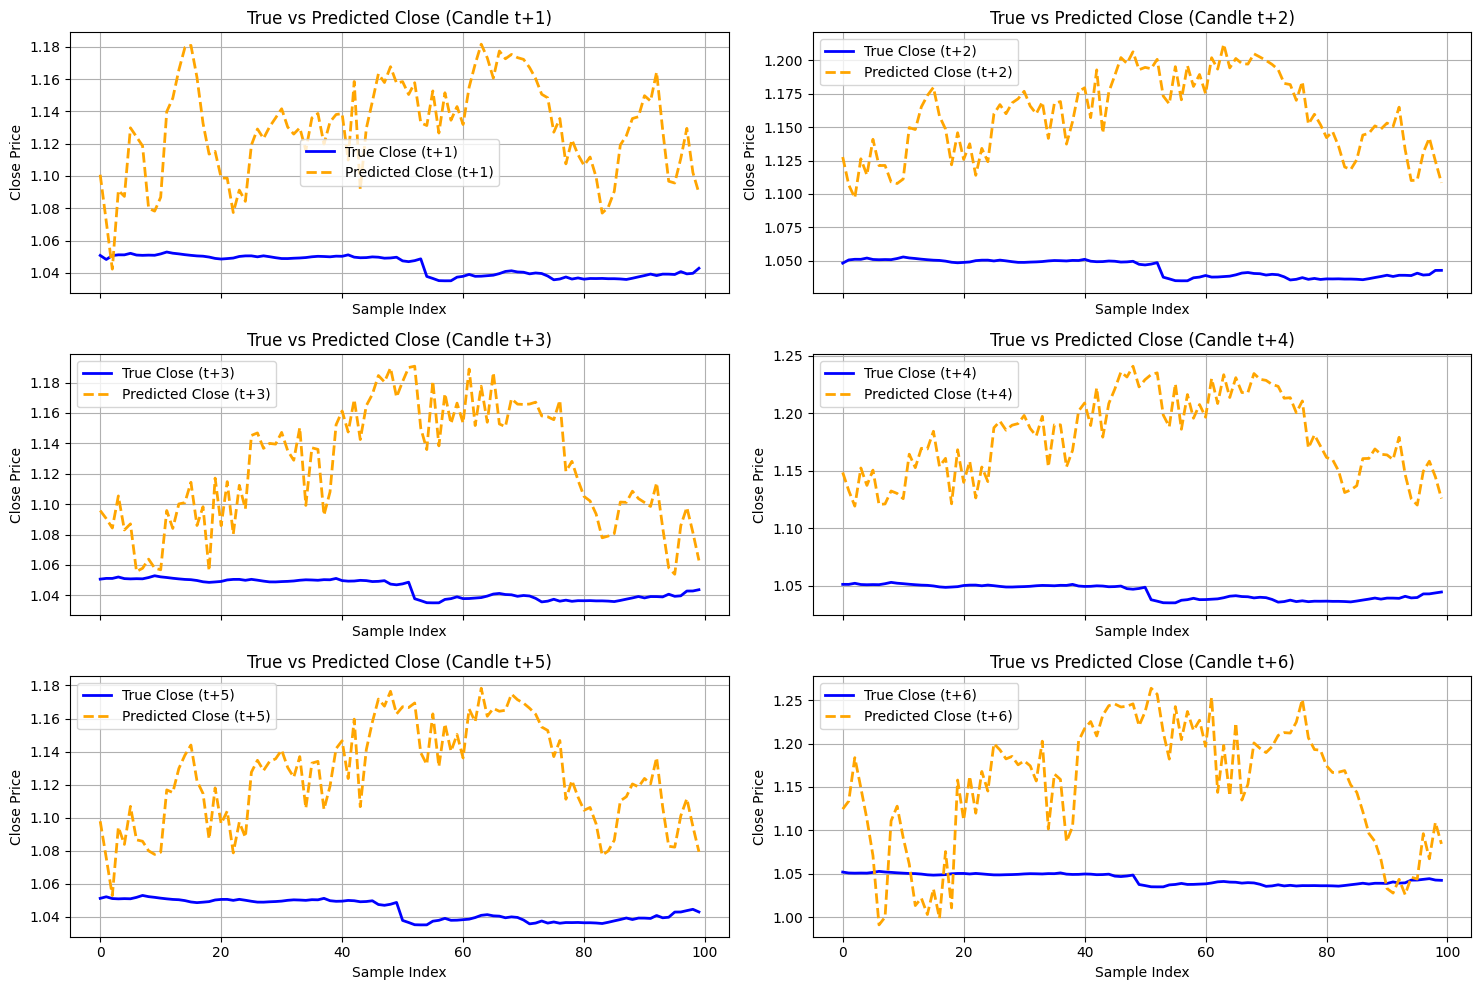

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# فرضاً داده‌ها و مدل رو داری
y_pred = model.predict(X_test)
y_test_inv = close_scaler.inverse_transform(y_test)
y_pred_inv = close_scaler.inverse_transform(y_pred)

# رسم ۶ نمودار جداگونه
n_display = 100
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

for i in range(6):
    y_true_plot = y_test_inv[-n_display:, i]  # مقادیر واقعی برای کندل i+1
    y_pred_plot = y_pred_inv[-n_display:, i]  # پیش‌بینی‌ها برای کندل i+1
    
    axes[i].plot(y_true_plot, label=f'True Close (t+{i+1})', color='blue', linewidth=2)
    axes[i].plot(y_pred_plot, label=f'Predicted Close (t+{i+1})', color='orange', linestyle='--', linewidth=2)
    axes[i].set_title(f'True vs Predicted Close (Candle t+{i+1})')
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Close Price')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


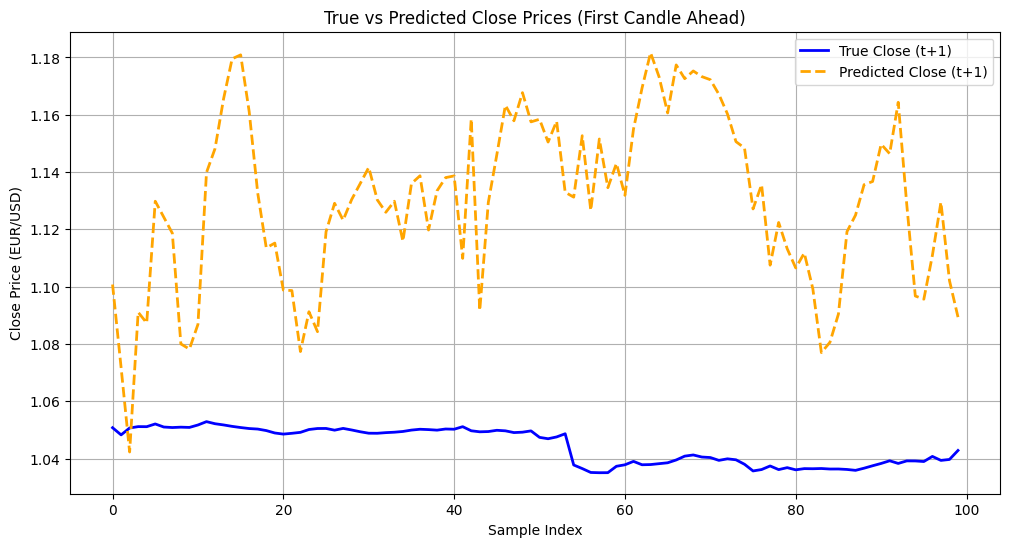

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# فرضاً مدل و داده‌ها رو داری
# model: مدل آموزش‌دیده (CNN-LSTM با Attention)
# X_test: داده‌های ورودی تست ([n_samples, 50, 30])
# y_test: مقادیر واقعی ([n_samples, 6])
# close_scaler: اسکالری که برای نرمال‌سازی کلوز استفاده شده

# ۱. تولید پیش‌بینی‌ها
y_pred = model.predict(X_test)  # [n_samples, 6]

# ۲. برگرداندن داده‌ها به مقیاس اصلی
y_test_inv = close_scaler.inverse_transform(y_test)  # مقادیر واقعی به مقیاس اصلی
y_pred_inv = close_scaler.inverse_transform(y_pred)  # پیش‌بینی‌ها به مقیاس اصلی

# ۳. انتخاب زیرمجموعه برای نمایش (مثلاً ۱۰۰ کندل آخر)
n_display = 100
y_true_plot = y_test_inv[-n_display:, 0]  # فقط کلوز اولین کندل بعدی (y_{t+1})
y_pred_plot = y_pred_inv[-n_display:, 0]  # پیش‌بینی اولین کندل بعدی (\hat{y}_{t+1})

# ۴. رسم لاین پلات
plt.figure(figsize=(12, 6))
plt.plot(y_true_plot, label='True Close (t+1)', color='blue', linewidth=2)
plt.plot(y_pred_plot, label='Predicted Close (t+1)', color='orange', linestyle='--', linewidth=2)
plt.title('True vs Predicted Close Prices (First Candle Ahead)')
plt.xlabel('Sample Index')
plt.ylabel('Close Price (EUR/USD)')
plt.legend()
plt.grid(True)
plt.show()